# Paris - City of Light
## Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## I. Introduction: Business Problem <a name="introduction"></a>

In this project we will try to help the **Mayor of Paris** and his colleagues nearby Paris to adjust the **City policies** in order to encourage **social diversity** and to increase the **attractiveness of the neighborhoods**.

Paris is a tremendous city of 2 million inhabitants, with a very rich offer of culture, history but also gastronomy and nature. Around, the "Ile de France" region is the biggest european region in terms of population and GDP. Real estate is quite expensive, and there are important discrepancies among the 20 Paris districts ("Arrondissements") and the cities which are very close to Paris.

Our project will focus on East Paris (10 arrondissements) and 10 surrounding cities close to East Paris. Data collection and interpretation will focus on two distinct parts:
- first, we will examine the **real estate** price per "Arrondissement" or city, based on the available public data of Real Estate transactions. We will calculate the average price per square meter per city.
- second, we will find the most **popular venues** and segment the neighborhoods according to the typology of their venues. Of course, Foursquera will be used to collect the associated data.

Once we have the Real Estate prices associated to each Quartier and the Venues profile, we will try to find a **correlation** between the two types of data and describe what is the **venue segment associated with a "expensive", "medium" and "low price" neighborhood**.

We will than use then our data science powers to make some recommendation for the Mayor in order to adjust the City Policies. Particularly, we will try to find **what kind of venues** should be encouraged in order to increase the **attractiveness of the low price neighborhoods**.

## II. Data <a name="data"></a>

Let's start by importing the necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

### II.1 The geographical region we will study

The geographical region we will focus on is East Paris and the cities close to paris on it's East side.

Let's start by having a look on this part of map.

In [2]:
latitude = 48.8534
longitude = 2.4488
# create map and display it
paris_east_map = folium.Map(location=[latitude, longitude], zoom_start=13)

# display the map of East Paris
paris_east_map

Let's mark on the map the boundaries of the **Cities** and **"Arrondissements"** we are interested in. 

We will use for this the GeoJson file available on https://france-geojson.gregoiredavid.fr

In [3]:
#windows version of wget
import wget

url = 'https://france-geojson.gregoiredavid.fr/repo/regions/ile-de-france/communes-ile-de-france.geojson'
filename = wget.download(url)

filename

communes_ile_de_france = r'communes-ile-de-france.geojson'
print(communes_ile_de_france)
folium.GeoJson(
    communes_ile_de_france
).add_to(paris_east_map)

paris_east_map

100% [............................................................................] 715186 / 715186communes-ile-de-france.geojson


In [3]:
!wget --quiet https://france-geojson.gregoiredavid.fr/repo/regions/ile-de-france/communes-ile-de-france.geojson -O communes-ile-de-france.geojson
    
print('GeoJSON file downloaded!')

communes_ile_de_france = r'communes-ile-de-france.geojson'
print(communes_ile_de_france)
folium.GeoJson(
    communes_ile_de_france
).add_to(paris_east_map)

paris_east_map

GeoJSON file downloaded!
communes-ile-de-france.geojson


The **city_list** is the collection of ZIP codes corresponding to the cities or Paris Arrondissements we are interested in

In [4]:
city_list = [75003, 75004, 75005, 75010, 75011, 75012, 75013, 75018, 75019, 75020, 93100, 93110, 93170, 93230, 93260, 93310, 93500, 94120, 94130, 94160, 94220, 94300, 94340, 94410]

### II.2 Data related to real estate transactions

Now let's collect the data associated with the real estate transactions in thsi region.

This data is public, and a full description (in French) can be found on the site below:
https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres-geolocalisees/

The brute data can be downloaded using the site https://www.data.gouv.fr/fr/datasets/les-communes-d-ile-de-france-idf/

I have uploaded into the IBM cloud the files corresponding to the real estate sales in 2018 in 3 departments from Ile de France:
    - 75 - Paris
    - 93 - Seine Saint Denis
    - 94 - Val de Marne

They correspond to teh Paris East Region we want to study.

The hidden code below import brute data into 3 pandas Dataframes

In [5]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_5fa043401dd344ca9d75c1ec1d1d6b13 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='fx7y0OF-K29wdDIUzSU6dWi1ypY9vEBzw251_M_qvcaE',
    ibm_auth_endpoint="https://iam.eu-de.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_5fa043401dd344ca9d75c1ec1d1d6b13.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-tbucqk0gnlwasx',Key='75_2018.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)

body = client_5fa043401dd344ca9d75c1ec1d1d6b13.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-tbucqk0gnlwasx',Key='93_2018.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)

body = client_5fa043401dd344ca9d75c1ec1d1d6b13.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-tbucqk0gnlwasx',Key='94_2018.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_3 = pd.read_csv(body)

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (18,20,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (14,17,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
import os
os.getcwd()

'/home/dsxuser/work'

In [88]:
#windows version

df_data_1 = pd.read_csv('D:\\Python\\WPy64-3741\\notebooks\\coursera_capstone\\Data\\75_2018.csv')
df_data_2 = pd.read_csv('D:\\Python\\WPy64-3741\\notebooks\\coursera_capstone\\Data\\93_2018.csv')
df_data_3 = pd.read_csv('D:\\Python\\WPy64-3741\\notebooks\\coursera_capstone\\Data\\94_2018.csv')

D:\Python\WPy64-3741\python-3.7.4.amd64\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,20,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\Python\WPy64-3741\python-3.7.4.amd64\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (14,17,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's concatenate these data into a sigle dataframe which we will call **restate_primary_data**. 

We get approx. 156,000 lines corresponding to unitary transactions on flats, houses, parkings, shops etc. sold in 2018 in these 3 departments.

In [6]:
df_list = [df_data_1, df_data_2, df_data_3]
restate_primary_data = pd.concat(df_list)

print (restate_primary_data.shape)
restate_primary_data.head()

(156424, 40)


id_mutation date_mutation  numero_disposition nature_mutation  \
0  2018-1276175    2018-01-04                   1           Vente   
1  2018-1276176    2018-01-09                   1           Vente   
2  2018-1276177    2018-01-05                   1           Vente   
3  2018-1276177    2018-01-05                   1           Vente   
4  2018-1276178    2018-01-03                   1           Vente   

   valeur_fonciere  adresse_numero adresse_suffixe  adresse_nom_voie  \
0        1202000.0            10.0             NaN        AV PERCIER   
1         130000.0            20.0             NaN  RUE SAINT CLAUDE   
2          51000.0            24.0             NaN     RUE TREILHARD   
3          51000.0            24.0             NaN     RUE TREILHARD   
4          15000.0            12.0             NaN         RUE VOLTA   

  adresse_code_voie  code_postal  code_commune              nom_commune  \
0              7250      75008.0         75108  Paris 8e Arrondissement   
1              8520      75003.0         75103  Paris 3e Arrondissement   
2              9429      75008.0         75108  Paris 8e Arrondissement   
3              9429      75008.0         75108  Paris 8e Arrondissement   
4              9905      75003.0         75103  Paris 3e Arrondissement   

   code_departement  ancien_code_commune ancien_nom_commune     id_parcelle  \
0                75                  NaN                NaN  75108000CJ0003   
1                75                  NaN                NaN  75103000AL0072   
2                75                  NaN                NaN  75108000CI0004   
3                75                  NaN                NaN  75108000CI0004   
4                75                  NaN                NaN  75103000AE0136   

   ancien_id_parcelle numero_volume lot1_numero  lot1_surface_carrez  \
0                 NaN           NaN          77                159.2   
1                 NaN           NaN         206                  NaN   
2                 NaN           NaN          20                  NaN   
3                 NaN           NaN          27                  NaN   
4                 NaN           NaN           7                  8.3   

  lot2_numero  lot2_surface_carrez  lot3_numero  lot3_surface_carrez  \
0          78                  NaN         79.0                  NaN   
1         213                  NaN        214.0                  NaN   
2         NaN                  NaN          NaN                  NaN   
3         NaN                  NaN          NaN                  NaN   
4         NaN                  NaN          NaN                  NaN   

   lot4_numero  lot4_surface_carrez  lot5_numero  lot5_surface_carrez  \
0          NaN                  NaN          NaN                  NaN   
1        216.0                  NaN          NaN                  NaN   
2          NaN                  NaN          NaN                  NaN   
3          NaN                  NaN          NaN                  NaN   
4          NaN                  NaN          NaN                  NaN   

   nombre_lots  code_type_local   type_local  surface_reelle_bati  \
0            3              2.0  Appartement                120.0   
1            4              2.0  Appartement                 22.0   
2            1              3.0   Dépendance                  NaN   
3            1              3.0   Dépendance                  NaN   
4            1              2.0  Appartement                  9.0   

   nombre_pieces_principales code_nature_culture nature_culture  \
0                        2.0                 NaN            NaN   
1                        1.0                 NaN            NaN   
2                        0.0                 NaN            NaN   
3                        0.0                 NaN            NaN   
4                        1.0                 NaN            NaN   

  code_nature_culture_speciale nature_culture_speciale  surface_terrain  \
0                          NaN  

We will keep only 13 usefull columns ans perform some data cleaning.

In [7]:
restate_primary_data = restate_primary_data[['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation', 'valeur_fonciere', 'adresse_numero', 'adresse_nom_voie', 'code_postal', 'nom_commune', 'type_local', 'surface_reelle_bati', 'longitude', 'latitude']]
restate_primary_data[['numero_disposition']] = 1
restate_primary_data.replace({'adresse_numero': np.NaN}, value=0, inplace=True)
restate_primary_data = restate_primary_data.astype({'adresse_numero': 'int64'}, copy=False)
restate_primary_data.replace({'code_postal': np.NaN}, value=0, inplace=True)
restate_primary_data = restate_primary_data.astype({'code_postal': 'int64'}, copy=False)
restate_primary_data.replace({'surface_reelle_bati': np.NaN}, value=0, inplace=True)
print (restate_primary_data.shape)
restate_primary_data.head()

(156424, 13)


id_mutation date_mutation  numero_disposition nature_mutation  \
0  2018-1276175    2018-01-04                   1           Vente   
1  2018-1276176    2018-01-09                   1           Vente   
2  2018-1276177    2018-01-05                   1           Vente   
3  2018-1276177    2018-01-05                   1           Vente   
4  2018-1276178    2018-01-03                   1           Vente   

   valeur_fonciere  adresse_numero  adresse_nom_voie  code_postal  \
0        1202000.0              10        AV PERCIER        75008   
1         130000.0              20  RUE SAINT CLAUDE        75003   
2          51000.0              24     RUE TREILHARD        75008   
3          51000.0              24     RUE TREILHARD        75008   
4          15000.0              12         RUE VOLTA        75003   

               nom_commune   type_local  surface_reelle_bati  longitude  \
0  Paris 8e Arrondissement  Appartement                120.0   2.315005   
1  Paris 3e Arrondissement  Appartement                 22.0   2.365335   
2  Paris 8e Arrondissement   Dépendance                  0.0   2.313122   
3  Paris 8e Arrondissement   Dépendance                  0.0   2.313122   
4  Paris 3e Arrondissement  Appartement                  9.0   2.357140   

    latitude  
0  48.874705  
1  48.860248  
2  48.877067  
3  48.877067  
4  48.864804

Here below is the list of zip codes for the Arrondissements and Cities we would like to study.

We will include the data for these cities into a new dataframe called **df_east_paris_primary**. We get a reduced list of approx. **56,000** elementary transactions.

In [8]:
city_list = [75003, 75004, 75005, 75010, 75011, 75012, 75013, 75018, 75019, 75020, 93100, 93110, 93170, 93230, 93260, 93310, 93500, 94120, 94130, 94160, 94220, 94300, 94340, 94410]

for code_city in city_list:
    if code_city == 75003:
        df_east_paris_primary = restate_primary_data.loc[restate_primary_data['code_postal'] == code_city]
    else:
        df_east_paris_primary = df_east_paris_primary.append(restate_primary_data.loc[restate_primary_data['code_postal'] == code_city])

df_east_paris_primary.shape

(55786, 13)

Let's take a look on how many elementary transactions we have per Arrondissement or City for our **city_list**

In [9]:
df_east_paris_primary.reset_index(drop=True, inplace=True)
df_east_paris_primary.groupby(['code_postal'])['nom_commune'].value_counts()

code_postal  nom_commune             
75003        Paris 3e Arrondissement     1347
75004        Paris 4e Arrondissement     1378
75005        Paris 5e Arrondissement     1383
75010        Paris 10e Arrondissement    3254
75011        Paris 11e Arrondissement    4832
75012        Paris 12e Arrondissement    3703
75013        Paris 13e Arrondissement    2883
75018        Paris 18e Arrondissement    6245
75019        Paris 19e Arrondissement    5134
75020        Paris 20e Arrondissement    3658
93100        Montreuil                   2693
93110        Rosny-sous-Bois             1813
93170        Bagnolet                     984
93230        Romainville                 5685
93260        Les Lilas                   1011
93310        Le Pré-Saint-Gervais         495
93500        Pantin                      1650
94120        Fontenay-sous-Bois          1630
94130        Nogent-sur-Marne            1342
94160        Saint-Mandé                  869
94220        Charenton-le-Pont            

What type of transactions do we have here?

In [10]:
df_east_paris_primary.groupby(['numero_disposition'])['nature_mutation'].value_counts()

numero_disposition  nature_mutation                   
1                   Vente                                 50583
                    Vente en l'état futur d'achèvement     4542
                    Echange                                 382
                    Adjudication                            181
                    Vente terrain à bâtir                    81
                    Expropriation                            17
Name: nature_mutation, dtype: int64

And how many objects have been transacted (appartment, houses, shops etc...)?

In [11]:
df_east_paris_primary.groupby(['numero_disposition'])['type_local'].value_counts()

numero_disposition  type_local                              
1                   Appartement                                 33133
                    Dépendance                                  12819
                    Local industriel. commercial ou assimilé     3842
                    Maison                                       1240
Name: type_local, dtype: int64

We will now keep only simple classical transactions (sale) and we will add category columns for the type of object sold (appartment, house etc.)

In [12]:
index_coll = df_east_paris_primary[df_east_paris_primary['nature_mutation'] == 'Adjudication'].index
index_coll = index_coll.append(df_east_paris_primary[df_east_paris_primary['nature_mutation'] == 'Echange'].index)
index_coll = index_coll.append(df_east_paris_primary[df_east_paris_primary['nature_mutation'] == 'Expropriation'].index)
index_coll = index_coll.append(df_east_paris_primary[df_east_paris_primary['nature_mutation'] == 'Vente terrain à bâtir'].index)
index_coll = index_coll.sort_values()
df_east_paris_primary.drop(index_coll, inplace=True)
df_east_paris_primary = pd.concat([df_east_paris_primary,pd.get_dummies(df_east_paris_primary['type_local'])], axis=1)
df_east_paris_primary.groupby(['numero_disposition'])['nature_mutation'].value_counts()
df_east_paris_primary.head()

id_mutation date_mutation  numero_disposition nature_mutation  \
0  2018-1276176    2018-01-09                   1           Vente   
1  2018-1276178    2018-01-03                   1           Vente   
2  2018-1276181    2018-01-09                   1           Vente   
3  2018-1276181    2018-01-09                   1           Vente   
4  2018-1276181    2018-01-09                   1           Vente   

   valeur_fonciere  adresse_numero  adresse_nom_voie  code_postal  \
0         130000.0              20  RUE SAINT CLAUDE        75003   
1          15000.0              12         RUE VOLTA        75003   
2        1840000.0             251  RUE SAINT MARTIN        75003   
3        1840000.0             251  RUE SAINT MARTIN        75003   
4        1840000.0             251  RUE SAINT MARTIN        75003   

               nom_commune   type_local  surface_reelle_bati  longitude  \
0  Paris 3e Arrondissement  Appartement                 22.0   2.365335   
1  Paris 3e Arrondissement  Appartement                  9.0   2.357140   
2  Paris 3e Arrondissement   Dépendance                  0.0   2.353682   
3  Paris 3e Arrondissement   Dépendance                  0.0   2.353682   
4  Paris 3e Arrondissement  Appartement                180.0   2.353682   

    latitude  Appartement  Dépendance  \
0  48.860248            1           0   
1  48.864804            1           0   
2  48.866408            0           1   
3  48.866408            0           1   
4  48.866408            1           0   

   Local industriel. commercial ou assimilé  Maison  
0                                         0       0  
1                                         0       0  
2                                         0       0  
3                                         0       0  
4                                         0       0

Now let's group the elements per transaction. We will keep a **single line per transaction** (while in the original files there was a line per object sold).

At the end, we havve approx. **32,000** of global transactions concerning this geographical zone.

In [13]:
df1 = df_east_paris_primary.groupby(['id_mutation', 'date_mutation', 'nature_mutation', 'code_postal', 'nom_commune'])\
    [['adresse_numero', 'adresse_nom_voie','valeur_fonciere', 'longitude', 'latitude']].max().reset_index()

df2 = df_east_paris_primary.groupby(['id_mutation'])\
    [['numero_disposition', 'surface_reelle_bati', 'Appartement', 'Dépendance', 'Local industriel. commercial ou assimilé', 'Maison']].sum().reset_index()

df3 = df1.join(df2.set_index('id_mutation'), on='id_mutation')
df3 = df3.astype({'Appartement': 'int64'}, copy=False)
df3 = df3.astype({'Dépendance': 'int64'}, copy=False)
df3 = df3.astype({'Local industriel. commercial ou assimilé': 'int64'}, copy=False)
df3 = df3.astype({'Maison': 'int64'}, copy=False)
print (df3.shape)
df3.head()

(32447, 16)


id_mutation date_mutation nature_mutation  code_postal  nom_commune  \
0  2018-1195952    2018-01-03           Vente        93230  Romainville   
1  2018-1195953    2018-01-08           Vente        93500       Pantin   
2  2018-1195954    2018-01-05           Vente        93170     Bagnolet   
3  2018-1195955    2018-01-05           Vente        93500       Pantin   
4  2018-1195958    2018-01-05           Vente        93260    Les Lilas   

   adresse_numero   adresse_nom_voie  valeur_fonciere  longitude   latitude  \
0              25  BD EMILE GENEVOIX         230000.0   2.435743  48.881934   
1               4      RUE LAPEROUSE          90000.0   2.393240  48.900227   
2               2  RUE DES LORIETTES         222000.0   2.420057  48.872363   
3              31         RUE DELIZY         278000.0   2.408445  48.896071   
4              45   BD DE LA LIBERTE         626400.0   2.420566  48.880405   

   numero_disposition  surface_reelle_bati  Appartement  Dépendance  \
0                   2                 59.0            1           1   
1                   1                 40.0            1           0   
2                   1                 55.0            1           0   
3                   2                 52.0            1           1   
4                   1                110.0            0           0   

   Local industriel. commercial ou assimilé  Maison  
0                                         0       0  
1                                         0       0  
2                                         0       0  
3                                         0       0  
4                                         0       1

We will now keep only the transactions concerning the **Appartments** and drop everything else. 

Final data will be stored in **east_paris_transactions** dataframe

In [14]:
index_coll = df3[df3['Local industriel. commercial ou assimilé'] >= 1].index
index_coll = index_coll.append(df3[df3['Maison'] >= 1].index)
index_coll = index_coll.append(df3[df3['Appartement'] < 1].index)
east_paris_transactions = df3.drop(index_coll)
east_paris_transactions.reset_index(drop=True, inplace=True)
print(east_paris_transactions.shape)

(23904, 16)


We will now calculate and enrich the dataframe with the **price per square meter**.

In [15]:
#insert a new column - prix au m2
east_paris_transactions['nombre_transactions'] = 1
east_paris_transactions['prix_m2'] = east_paris_transactions['valeur_fonciere'] / east_paris_transactions['surface_reelle_bati']

east_paris_transactions.head()

id_mutation date_mutation nature_mutation  code_postal  nom_commune  \
0  2018-1195952    2018-01-03           Vente        93230  Romainville   
1  2018-1195953    2018-01-08           Vente        93500       Pantin   
2  2018-1195954    2018-01-05           Vente        93170     Bagnolet   
3  2018-1195955    2018-01-05           Vente        93500       Pantin   
4  2018-1195960    2018-01-05           Vente        93500       Pantin   

   adresse_numero   adresse_nom_voie  valeur_fonciere  longitude   latitude  \
0              25  BD EMILE GENEVOIX         230000.0   2.435743  48.881934   
1               4      RUE LAPEROUSE          90000.0   2.393240  48.900227   
2               2  RUE DES LORIETTES         222000.0   2.420057  48.872363   
3              31         RUE DELIZY         278000.0   2.408445  48.896071   
4             143     AV JEAN LOLIVE         695000.0   2.412250  48.893774   

   numero_disposition  surface_reelle_bati  Appartement  Dépendance  \
0                   2                 59.0            1           1   
1                   1                 40.0            1           0   
2                   1                 55.0            1           0   
3                   2                 52.0            1           1   
4                   3                107.0            1           2   

   Local industriel. commercial ou assimilé  Maison  nombre_transactions  \
0                                         0       0                    1   
1                                         0       0                    1   
2                                         0       0                    1   
3                                         0       0                    1   
4                                         0       0                    1   

       prix_m2  
0  3898.305085  
1  2250.000000  
2  4036.363636  
3  5346.153846  
4  6495.327103

Let's take a look at the distribution of price per square meter in our data, city by city. We will use a boxplot graph.

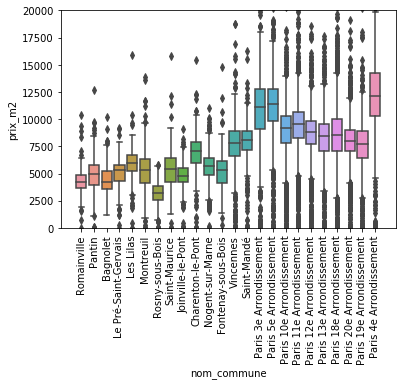

In [16]:
sns.boxplot(x="nom_commune", y="prix_m2", data=east_paris_transactions)
plt.ylim(0, 20000)
plt.xticks(rotation=90)
plt.autoscale(enable=True, axis='x')

So, depending on the cityes, median price go between **3000€/m²** and more than **12000€/m²**.

Let's take a look at the outliers, and simply drop them (pirces per squere meter above 20000€ or below 500€). The number of transactions we will keep per city is herebelow.

In [17]:
index_coll = east_paris_transactions[east_paris_transactions['prix_m2'] > 20000].index
index_coll = index_coll.append(east_paris_transactions[east_paris_transactions['prix_m2'] < 500].index)
east_paris_transactions = east_paris_transactions.drop(index_coll)
east_paris_transactions.reset_index(drop=True, inplace=True)
print(east_paris_transactions.shape)

east_paris_transactions.groupby(['code_postal', 'nom_commune'])['nombre_transactions'].sum()

(23367, 18)


code_postal  nom_commune             
75003        Paris 3e Arrondissement      760
75004        Paris 4e Arrondissement      524
75005        Paris 5e Arrondissement      824
75010        Paris 10e Arrondissement    1627
75011        Paris 11e Arrondissement    2561
75012        Paris 12e Arrondissement    1675
75013        Paris 13e Arrondissement    1576
75018        Paris 18e Arrondissement    3626
75019        Paris 19e Arrondissement    1829
75020        Paris 20e Arrondissement    2123
93100        Montreuil                   1035
93110        Rosny-sous-Bois              472
93170        Bagnolet                     312
93230        Romainville                  205
93260        Les Lilas                    275
93310        Le Pré-Saint-Gervais         198
93500        Pantin                       643
94120        Fontenay-sous-Bois           430
94130        Nogent-sur-Marne             572
94160        Saint-Mandé                  407
94220        Charenton-le-Pont            

#### To resume, we have now, in the dataframe east_paris_transactions the list of real estate transactions from 2018 in the cities of our choice, with the associated price / squere meter

#### This list contains approx. 23,000 transactions

### II.3 Divide geographical space in square tiles

Now let's analyse the geographical shape of our list of cities and divide this surface in a grid of 15x15 tiles.

In [18]:
bins_lat = np.linspace(min(east_paris_transactions['latitude']), max(east_paris_transactions['latitude']), 16)
lat_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
east_paris_transactions['bins_lat'] = pd.cut(east_paris_transactions['latitude'], bins_lat, labels=lat_names, include_lowest=True)
bins_long = np.linspace(min(east_paris_transactions['longitude']), max(east_paris_transactions['longitude']), 16)
long_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
east_paris_transactions['bins_long'] = pd.cut(east_paris_transactions['longitude'], bins_long, labels=long_names, include_lowest=True)

east_paris_transactions.head()

id_mutation date_mutation nature_mutation  code_postal  nom_commune  \
0  2018-1195952    2018-01-03           Vente        93230  Romainville   
1  2018-1195953    2018-01-08           Vente        93500       Pantin   
2  2018-1195954    2018-01-05           Vente        93170     Bagnolet   
3  2018-1195955    2018-01-05           Vente        93500       Pantin   
4  2018-1195960    2018-01-05           Vente        93500       Pantin   

   adresse_numero   adresse_nom_voie  valeur_fonciere  longitude   latitude  \
0              25  BD EMILE GENEVOIX         230000.0   2.435743  48.881934   
1               4      RUE LAPEROUSE          90000.0   2.393240  48.900227   
2               2  RUE DES LORIETTES         222000.0   2.420057  48.872363   
3              31         RUE DELIZY         278000.0   2.408445  48.896071   
4             143     AV JEAN LOLIVE         695000.0   2.412250  48.893774   

   numero_disposition  surface_reelle_bati  Appartement  Dépendance  \
0                   2                 59.0            1           1   
1                   1                 40.0            1           0   
2                   1                 55.0            1           0   
3                   2                 52.0            1           1   
4                   3                107.0            1           2   

   Local industriel. commercial ou assimilé  Maison  nombre_transactions  \
0                                         0       0                    1   
1                                         0       0                    1   
2                                         0       0                    1   
3                                         0       0                    1   
4                                         0       0                    1   

       prix_m2 bins_lat bins_long  
0  3898.305085       10         9  
1  2250.000000       12         5  
2  4036.363636        8         7  
3  5346.153846       12         6  
4  6495.327103       11         7

We will calculate now the average **price / square meter** and the **number of transactions** which occured in each tile.

In [19]:
tiles = east_paris_transactions.groupby(['bins_lat','bins_long'])['prix_m2'].mean().reset_index()
tiles.set_index(['bins_lat', 'bins_long'])

tiles2 = east_paris_transactions.groupby(['bins_lat','bins_long'])['nombre_transactions'].sum().reset_index()
tiles2.set_index(['bins_lat', 'bins_long'])

tiles= tiles.join(tiles2.set_index(['bins_lat', 'bins_long']), on=['bins_lat','bins_long'])
tiles = tiles.dropna().set_index(['bins_lat', 'bins_long']).reset_index()
tiles = tiles.astype({'nombre_transactions': 'int64'}, copy=False)
tiles.head()

bins_lat bins_long      prix_m2  nombre_transactions
0        0         7  5664.557788                   35
1        0         8  6827.312677                   20
2        0         9  5282.868018                    4
3        0        10  5288.182929                   37
4        0        11  4720.313914                  164

Let's enrich this tile list with the geographical information (latitude, longitude, square borders)

In [20]:
for lat in range(0, 15):
    index_list = tiles[tiles['bins_lat']==lat].index
    for k in index_list:
        tiles.at[k, 'lat_s'] = bins_lat[lat]
        tiles.at[k, 'lat_n'] = bins_lat[lat+1]
        tiles.at[k, 'latitude'] = (bins_lat[lat] + bins_lat[lat+1])/2

for long in range(0, 15):
    index_list = tiles[tiles['bins_long']==long].index
    for k in index_list:
        tiles.at[k, 'long_w'] = bins_long[long]
        tiles.at[k, 'long_e'] = bins_long[long+1]
        tiles.at[k, 'longitude'] = (bins_long[long] + bins_long[long+1])/2

for i in tiles.index:
    s = "{0}_{1}".format (tiles.loc[i, 'bins_lat'], tiles.loc[i, 'bins_long'],)
    tiles.loc[i, 'tile_id'] = s

tiles.head()

bins_lat bins_long      prix_m2  nombre_transactions      lat_s      lat_n  \
0        0         7  5664.557788                   35  48.811961  48.818836   
1        0         8  6827.312677                   20  48.811961  48.818836   
2        0         9  5282.868018                    4  48.811961  48.818836   
3        0        10  5288.182929                   37  48.811961  48.818836   
4        0        11  4720.313914                  164  48.811961  48.818836   

    latitude    long_w    long_e  longitude tile_id  
0  48.815398  2.410483  2.422537   2.416510     0_7  
1  48.815398  2.422537  2.434592   2.428565     0_8  
2  48.815398  2.434592  2.446647   2.440619     0_9  
3  48.815398  2.446647  2.458701   2.452674    0_10  
4  48.815398  2.458701  2.470756   2.464729    0_11

Let's have a look of how these tiles map the list of cities and arrondissements we are interested in.

Prior, we will define a function **rectTile** which allows to create a json geometrical square object. Then, build a GeoJson file which contains the list of all our tiles.

In [21]:
def rectTile(tile_ids, long_w_list, long_e_list, lat_s_list, lat_n_list):
    
    tile_list=[]
    for tile_id, long_w, long_e, lat_s, lat_n,  in zip(tile_ids, long_w_list, long_e_list, lat_s_list, lat_n_list):
                 
        # print("tile_id ", tile_id)
        # return only relevant information for each nearby venue
        tile_list.append(
             {"type":"Feature",\
                "geometry":\
                  {"type":"Polygon",\
                     "coordinates":[[[long_w, lat_s],[long_w, lat_n],[long_e, lat_n],[long_e, lat_s]]]},\
                "properties":{"tile_id":tile_id}})
    return(tile_list)

east_tile_list = rectTile(tile_ids=tiles['tile_id'],
                                    long_w_list=tiles['long_w'],
                                    long_e_list=tiles['long_e'],
                                    lat_s_list=tiles['lat_s'],
                                    lat_n_list=tiles['lat_n']                                                                
                                  )

east_tiles = {"type":"FeatureCollection",\
"features": east_tile_list}

f = open('all_tiles.json', 'w')
json.dump(east_tiles, f)
f.close()

Now let's show the map, with the border of cities and the initial list of tiles we have built

In [22]:
latitude = 48.8534
longitude = 2.4488
# create map and display it
paris_east_map = folium.Map(location=[latitude, longitude], zoom_start=13)

folium.GeoJson(
    communes_ile_de_france
).add_to(paris_east_map)

workfile = r'all_tiles.json'
print(workfile)

folium.GeoJson(
    workfile
).add_to(paris_east_map)

paris_east_map

all_tiles.json


On the top of that, center the circles in which we will look for Foursquera venues. The optimal radius seems to be 380 meters.

In [23]:
for lat, lon in zip(tiles['latitude'], tiles['longitude']):
    #print (lat, lon)
    folium.Circle([lat, lon], radius=380, color='blue', fill=False).add_to(paris_east_map)
paris_east_map

Looks good, but it is a little bit clumsy :-(

### II.4 Foursquera

In [24]:
# @hidden_cell
CLIENT_ID = 'WRGTBGWVIWD1S0LLK0GRGEARWM2GBYEQ1QOP0PSIPNBJHOUT' # your Foursquare ID
CLIENT_SECRET = 'VALOPUUYGGEAIWKNIW5WVQRIIGYRO2EZJ0LOTKT1JDXXECKF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

Now, let's get the venues for the list of tiles we have built

In [25]:
def getNearbyVenues(tile_ids, latitudes, longitudes, radius=550, LIMIT=100):
    
    venues_list=[]
    for tile_id, lat, lng in zip(tile_ids, latitudes, longitudes):
                 
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        #print(url)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        print("tile_id ", tile_id, ": ", len(results), " venues")
        # return only relevant information for each nearby venue
        venues_list.append([(
            tile_id,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['tile_id',
                  'Tile Latitude', 
                  'Tile Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

paris_east_venues = getNearbyVenues(tile_ids=tiles['tile_id'],
                                    latitudes=tiles['latitude'],
                                    longitudes=tiles['longitude']
                                  )

paris_east_venues.tail(20)

tile_id  0_7 :  8  venues
tile_id  0_8 :  5  venues
tile_id  0_9 :  4  venues
tile_id  0_10 :  6  venues
tile_id  0_11 :  8  venues
tile_id  0_12 :  7  venues
tile_id  1_1 :  27  venues
tile_id  1_2 :  67  venues
tile_id  1_3 :  63  venues
tile_id  1_4 :  7  venues
tile_id  1_5 :  28  venues
tile_id  1_6 :  17  venues
tile_id  1_7 :  9  venues
tile_id  1_8 :  4  venues
tile_id  1_11 :  13  venues
tile_id  1_12 :  7  venues
tile_id  2_1 :  53  venues
tile_id  2_2 :  93  venues
tile_id  2_3 :  37  venues
tile_id  2_4 :  45  venues
tile_id  2_6 :  4  venues
tile_id  2_11 :  5  venues
tile_id  2_12 :  5  venues
tile_id  2_13 :  9  venues
tile_id  3_1 :  52  venues
tile_id  3_2 :  100  venues
tile_id  3_3 :  33  venues
tile_id  3_4 :  59  venues
tile_id  3_5 :  63  venues
tile_id  3_6 :  36  venues
tile_id  3_7 :  8  venues
tile_id  3_11 :  5  venues
tile_id  3_12 :  6  venues
tile_id  3_13 :  18  venues
tile_id  3_14 :  4  venues
tile_id  4_0 :  65  venues
tile_id  4_1 :  69  venues
tile_i

tile_id  Tile Latitude  Tile Longitude                           Venue  \
5167    13_6      48.904773        2.404455                          MurMur   
5168    13_6      48.904773        2.404455                         Mondial   
5169    13_6      48.904773        2.404455                   Beleck Hotels   
5170    13_6      48.904773        2.404455       Compagnie d'arc de Pantin   
5171    13_7      48.904773        2.416510                     Tang Frères   
5172    13_7      48.904773        2.416510                        Carglass   
5173    13_7      48.904773        2.416510                       kedy pack   
5174    13_7      48.904773        2.416510                 Comfort Bobigny   
5175    14_5      48.911648        2.392401                       KIngooroo   
5176    14_5      48.911648        2.392401                         Sportil   
5177    14_6      48.911648        2.404455        Théatre Équestre Zingaro   
5178    14_6      48.911648        2.404455            In Situ Art Festival   
5179    14_6      48.911648        2.404455  Métro Fort d'Aubervilliers [7]   
5180    14_6      48.911648        2.404455             ASPTT Aubervilliers   
5181    14_7      48.911648        2.416510                Les Courtilleres   
5182    14_7      48.911648        2.416510     Cafétéria Le Pont De Pierre   
5183    14_7      48.911648        2.416510              Boulangerie Louise   
5184    14_7      48.911648        2.416510               Hotel B&B Bobigny   
5185    14_7      48.911648        2.416510             Stade Marcel Cerdan   
5186    14_7      48.911648        2.416510        Stade Interdepartemental   

      Venue Latitude  Venue Longitude                Venue Category  
5167       48.902748         2.401252                  Climbing Gym  
5168       48.902135         2.406884                  Home Service  
5169       48.902233         2.400651                    Hotel Pool  
5170       48.909057         2.401340          Gym / Fitness Center  
5171       48.903145         2.417425                   Supermarket  
5172       48.902950         2.416687             Other Repair Shop  
5173       48.904234         2.419432              Department Store  
5174       48.905784         2.422496                         Hotel  
5175       48.907874         2.395802  Theme Park Ride / Attraction  
5176       48.909728         2.398552            Athletics & Sports  
5177       48.913312         2.403522         Performing Arts Venue  
5178       48.911218         2.404677                    Street Art  
5179       48.914680         2.403635                 Metro Station  
5180       48.915901         2.406920                  Soccer Field  
5181       48.913096         2.417603                   Bus Station  
5182       48.913123         2.420003                         Diner  
5183       48.909757         2.412532                        Bakery  
5184       48.915527         2.417319                         Hotel  
5185       48.908944         2.421295                  Soccer Field  
5186       48.908654         2.421443            Athletics & Sports

How many venues do we have?

A quick histogram will help to understand how many venues we have per tile.

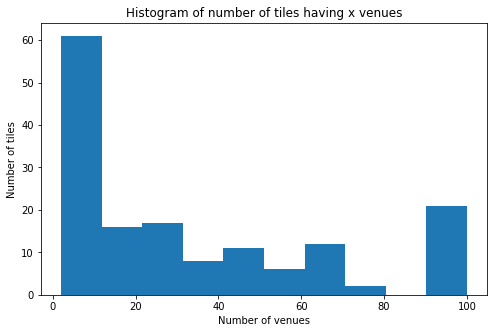

In [26]:
paris_east_venues['nombre_venues'] = 1
venues_per_tile = paris_east_venues.groupby(['tile_id','Tile Latitude', 'Tile Longitude'])['nombre_venues'].sum().reset_index()

# np.histogram returns 2 values
count, bin_edges = np.histogram(venues_per_tile['nombre_venues'])

#print(count) # frequency count
#print(bin_edges) # bin ranges, default = 10 bins

venues_per_tile['nombre_venues'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of number of tiles having x venues') # add a title to the histogram
plt.ylabel('Number of tiles') # add y-label
plt.xlabel('Number of venues') # add x-label

plt.show()

So, there are approx. 60 tiles on our area, having a very small (less than 10) number of interesting venues.

No let's add the number of venues to each tile of our **tiles** dataframe

In [27]:
tiles= tiles.join(venues_per_tile.set_index(['tile_id']), on=['tile_id'])
tiles.head()

bins_lat bins_long      prix_m2  nombre_transactions      lat_s      lat_n  \
0        0         7  5664.557788                   35  48.811961  48.818836   
1        0         8  6827.312677                   20  48.811961  48.818836   
2        0         9  5282.868018                    4  48.811961  48.818836   
3        0        10  5288.182929                   37  48.811961  48.818836   
4        0        11  4720.313914                  164  48.811961  48.818836   

    latitude    long_w    long_e  longitude tile_id  Tile Latitude  \
0  48.815398  2.410483  2.422537   2.416510     0_7      48.815398   
1  48.815398  2.422537  2.434592   2.428565     0_8      48.815398   
2  48.815398  2.434592  2.446647   2.440619     0_9      48.815398   
3  48.815398  2.446647  2.458701   2.452674    0_10      48.815398   
4  48.815398  2.458701  2.470756   2.464729    0_11      48.815398   

   Tile Longitude  nombre_venues  
0        2.416510              8  
1        2.428565              5  
2        2.440619              4  
3        2.452674              6  
4        2.464729              8

We will drop the tiles which have less than 20 real estate transactions and less then 4 venues.

In [28]:
index_coll = tiles[tiles['nombre_transactions']<20].index
tiles=tiles.drop(index_coll)
tiles.reset_index(drop=True, inplace=True)
index_coll = tiles[tiles['nombre_venues']<4].index
tiles=tiles.drop(index_coll)
tiles.reset_index(drop=True, inplace=True)
tiles.head()

bins_lat bins_long      prix_m2  nombre_transactions      lat_s      lat_n  \
0        0         7  5664.557788                   35  48.811961  48.818836   
1        0         8  6827.312677                   20  48.811961  48.818836   
2        0        10  5288.182929                   37  48.811961  48.818836   
3        0        11  4720.313914                  164  48.811961  48.818836   
4        0        12  4345.646138                   21  48.811961  48.818836   

    latitude    long_w    long_e  longitude tile_id  Tile Latitude  \
0  48.815398  2.410483  2.422537   2.416510     0_7      48.815398   
1  48.815398  2.422537  2.434592   2.428565     0_8      48.815398   
2  48.815398  2.446647  2.458701   2.452674    0_10      48.815398   
3  48.815398  2.458701  2.470756   2.464729    0_11      48.815398   
4  48.815398  2.470756  2.482811   2.476783    0_12      48.815398   

   Tile Longitude  nombre_venues  
0        2.416510              8  
1        2.428565              5  
2        2.452674              6  
3        2.464729              8  
4        2.476783              7

#### Our tiles dataframe contains now a list of geographical square zones, with the average price per square meter, the number of real estate transactions and the numbre of venues of interest for each tile

### II.5 Show real estate and number of venues on the same map

Our final part of the data analysis is to figure out - on the same map:
    - the average price per square meter
    - the number of venues
for all the tiles which cover our interest area

Let's rebuild our **east_tile_list** and generate a GeoJson file coresponding to the list of tiles of interest

In [29]:
east_tile_list = rectTile(tile_ids=tiles['tile_id'],
                                    long_w_list=tiles['long_w'],
                                    long_e_list=tiles['long_e'],
                                    lat_s_list=tiles['lat_s'],
                                    lat_n_list=tiles['lat_n']                                                                
                                  )

east_tile_list
east_tiles = {"type":"FeatureCollection",\
"features": east_tile_list}

f = open('east_tiles.json', 'w')

json.dump(east_tiles, f)

f.close()

Using a choropleth map, we will show the averag price per square meter in the various zones of interest

In [30]:
workfile = r'east_tiles.json'
print(workfile)

latitude = 48.8534
longitude = 2.4488
# create map and display it
paris_east_map = folium.Map(location=[latitude, longitude], zoom_start=13)

folium.GeoJson(
    workfile
).add_to(paris_east_map)

paris_east_map

paris_east_map.choropleth(
    geo_data=workfile,
    data=tiles,
    columns=['tile_id', 'prix_m2'],
    key_on='feature.properties.tile_id',
    fill_color='YlOrRd', 
    fill_opacity=0.5, 
    line_opacity=0.2,
    legend_name='Real Estate price per square meter'
)

paris_east_map

east_tiles.json


On the top of this we will add circle markers. The radius and color will represent the number of venues available in the tail (with a maximum of 100)

In [31]:
# set color scheme for the clusters
x = np.arange(0,100)
ys = [i + x + (i*x)**2 for i in range(0,100)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



for lat, lng, nbv, nbt, prix in zip(tiles['Tile Latitude'], tiles['Tile Longitude'], tiles['nombre_venues'], tiles['nombre_transactions'], tiles['prix_m2']):
    label = '{:.0f} €/m2, {} transactions, {} venues'.format(prix, nbt, nbv)
    folium.CircleMarker(
        [lat, lng],
        radius=3+12*(nbv/100), # define how big you want the circle markers to be
       color=rainbow[nbv-1],
        fill=True,
       popup=label,
        fill_color=rainbow[nbv-1],
        fill_opacity=0.5
).add_to(paris_east_map)   
    

# display map
paris_east_map

In [32]:
paris_east_venues.head()

tile_id  Tile Latitude  Tile Longitude  \
0     0_7      48.815398         2.41651   
1     0_7      48.815398         2.41651   
2     0_7      48.815398         2.41651   
3     0_7      48.815398         2.41651   
4     0_7      48.815398         2.41651   

                                   Venue  Venue Latitude  Venue Longitude  \
0                     Casino Supermarché       48.815013         2.419687   
1                [325] Général De Gaulle       48.814413         2.415398   
2                    Sushi d'Alfortville       48.814505         2.413889   
3  Arrêt Général de Gaulle [103,125,325]       48.814136         2.414217   
4                 Hôtel Au Petit Caporal       48.815199         2.419984   

        Venue Category  nombre_venues  
0          Supermarket              1  
1          Bus Station              1  
2  Japanese Restaurant              1  
3             Bus Stop              1  
4                Hotel              1

In [34]:
ven_cat = paris_east_venues.groupby(['Venue Category'])['nombre_venues'].sum().reset_index()
ven_cat

Venue Category  nombre_venues
0                  Accessories Store              2
1                  Afghan Restaurant              1
2                 African Restaurant             19
3                Alsatian Restaurant              1
4                American Restaurant             11
5                       Antique Shop              2
6                           Aquarium              2
7                             Arcade              1
8                   Arepa Restaurant              2
9             Argentinian Restaurant             13
10                       Art Gallery             28
11                        Art Museum              9
12               Arts & Crafts Store              9
13                  Asian Restaurant             60
14                Athletics & Sports              6
15                   Auto Dealership              1
16                       Auto Garage              2
17                     Auto Workshop              1
18                   Automotive Shop              1
19               Auvergne Restaurant              2
20                         BBQ Joint              6
21                        Baby Store              1
22                        Bagel Shop              8
23                            Bakery            154
24                               Bar            255
25                  Baseball Stadium              2
26                  Basketball Court              3
27                 Basque Restaurant              4
28                             Beach              1
29                   Bed & Breakfast              4
30                          Beer Bar             26
31                       Beer Garden             10
32                        Beer Store             12
33                Belgian Restaurant              1
34          Bike Rental / Bike Share             15
35                            Bistro            135
36                     Boat or Ferry              6
37                         Bookstore             45
38                  Botanical Garden              3
39                          Boutique              4
40                     Bowling Alley              6
41                        Boxing Gym              2
42                         Brasserie             19
43              Brazilian Restaurant              7
44                    Breakfast Spot             13
45                 Breton Restaurant              1
46                           Brewery             12
47                            Bridge              2
48                   Bubble Tea Shop              3
49                      Burger Joint             42
50             Burgundian Restaurant              1
51                     Burrito Place              3
52                          Bus Line              1
53                       Bus Station              7
54                          Bus Stop             38
55                  Business Service              3
56                           Butcher              2
57                         Cafeteria              5
58                              Café            137
59         Cajun / Creole Restaurant              2
60              Cambodian Restaurant              6
61                        Campground              1
62                             Canal              4
63                        Canal Lock              4
64                       Candy Store              4
65              Cantonese Restaurant              6
66              Caribbean Restaurant              2
67                            Castle              2
68              Caucasian Restaurant              1
69                          Cemetery              1
70                       Cheese Shop             13
71                Chinese Restaurant             59
72                    Chocolate Shop              9
73                            Church              2
74                            Circus              3
75                      Climbing Gym              3
76                

In [35]:
paris_east_venues.to_csv('paris_east_venues.csv', index=False)

In [36]:
paris_east_venues.head(100)

tile_id  Tile Latitude  Tile Longitude  \
0      0_7      48.815398        2.416510   
1      0_7      48.815398        2.416510   
2      0_7      48.815398        2.416510   
3      0_7      48.815398        2.416510   
4      0_7      48.815398        2.416510   
5      0_7      48.815398        2.416510   
6      0_7      48.815398        2.416510   
7      0_7      48.815398        2.416510   
8      0_8      48.815398        2.428565   
9      0_8      48.815398        2.428565   
10     0_8      48.815398        2.428565   
11     0_8      48.815398        2.428565   
12     0_8      48.815398        2.428565   
13     0_9      48.815398        2.440619   
14     0_9      48.815398        2.440619   
15     0_9      48.815398        2.440619   
16     0_9      48.815398        2.440619   
17    0_10      48.815398        2.452674   
18    0_10      48.815398        2.452674   
19    0_10      48.815398        2.452674   
20    0_10      48.815398        2.452674   
21    0_10      48.815398        2.452674   
22    0_10      48.815398        2.452674   
23    0_11      48.815398        2.464729   
24    0_11      48.815398        2.464729   
25    0_11      48.815398        2.464729   
26    0_11      48.815398        2.464729   
27    0_11      48.815398        2.464729   
28    0_11      48.815398        2.464729   
29    0_11      48.815398        2.464729   
30    0_11      48.815398        2.464729   
31    0_12      48.815398        2.476783   
32    0_12      48.815398        2.476783   
33    0_12      48.815398        2.476783   
34    0_12      48.815398        2.476783   
35    0_12      48.815398        2.476783   
36    0_12      48.815398        2.476783   
37    0_12      48.815398        2.476783   
38     1_1      48.822273        2.344182   
39     1_1      48.822273        2.344182   
40     1_1      48.822273        2.344182   
41     1_1      48.822273        2.344182   
42     1_1      48.822273        2.344182   
43     1_1      48.822273        2.344182   
44     1_1      48.822273        2.344182   
45     1_1      48.822273        2.344182   
46     1_1      48.822273        2.344182   
47     1_1      48.822273        2.344182   
48     1_1      48.822273        2.344182   
49     1_1      48.822273        2.344182   
50     1_1      48.822273        2.344182   
51     1_1      48.822273        2.344182   
52     1_1      48.822273        2.344182   
53     1_1      48.822273        2.344182   
54     1_1      48.822273        2.344182   
55     1_1      48.822273        2.344182   
56     1_1      48.822273        2.344182   
57     1_1      48.822273        2.344182   
58     1_1      48.822273        2.344182   
59     1_1      48.822273        2.344182   
60     1_1      48.822273        2.344182   
61     1_1      48.822273        2.344182   
62     1_1      48.822273        2.344182   
63     1_1      48.822273        2.344182   
64     1_1      48.822273        2.344182   
65     1_2      48.822273        2.356237   
66     1_2      48.822273        2.356237   
67     1_2      48.822273        2.356237   
68     1_2      48.822273        2.356237   
69     1_2      48.822273        2.356237   
70     1_2      48.822273        2.356237   
71     1_2      48.822273        2.356237   
72     1_2      48.822273        2.356237   
73     1_2      48.822273        2.356237   
74     1_2      48.822273        2.356237   
75     1_2      48.822273        2.356237   
76     1_2      48.822273        2.356237   
77     1_2      48.822273        2.356237   
78     1_2      48.822273        2.356237   
79     1_2      48.822273        2.356237   
80     1_2      48.822273        2.356237   
81     1_2      48.822273        2.356237   
82     1_2      48.822273        2.356237   
83     1_2      48.822273        2.356237   
84     1_2      48.822273        2.356237   
85     1_2      48.822273        2.356237   
86     1_2      48.822273        2.356237   
87     1_2      48.822273        2.356237  

In [38]:
paris_east_venues2 = pd.read_csv('paris_east_venues.csv')

In [39]:
paris_east_venues2.head(100)

tile_id  Tile Latitude  Tile Longitude  \
0      0_7      48.815398        2.416510   
1      0_7      48.815398        2.416510   
2      0_7      48.815398        2.416510   
3      0_7      48.815398        2.416510   
4      0_7      48.815398        2.416510   
5      0_7      48.815398        2.416510   
6      0_7      48.815398        2.416510   
7      0_7      48.815398        2.416510   
8      0_8      48.815398        2.428565   
9      0_8      48.815398        2.428565   
10     0_8      48.815398        2.428565   
11     0_8      48.815398        2.428565   
12     0_8      48.815398        2.428565   
13     0_9      48.815398        2.440619   
14     0_9      48.815398        2.440619   
15     0_9      48.815398        2.440619   
16     0_9      48.815398        2.440619   
17    0_10      48.815398        2.452674   
18    0_10      48.815398        2.452674   
19    0_10      48.815398        2.452674   
20    0_10      48.815398        2.452674   
21    0_10      48.815398        2.452674   
22    0_10      48.815398        2.452674   
23    0_11      48.815398        2.464729   
24    0_11      48.815398        2.464729   
25    0_11      48.815398        2.464729   
26    0_11      48.815398        2.464729   
27    0_11      48.815398        2.464729   
28    0_11      48.815398        2.464729   
29    0_11      48.815398        2.464729   
30    0_11      48.815398        2.464729   
31    0_12      48.815398        2.476783   
32    0_12      48.815398        2.476783   
33    0_12      48.815398        2.476783   
34    0_12      48.815398        2.476783   
35    0_12      48.815398        2.476783   
36    0_12      48.815398        2.476783   
37    0_12      48.815398        2.476783   
38     1_1      48.822273        2.344182   
39     1_1      48.822273        2.344182   
40     1_1      48.822273        2.344182   
41     1_1      48.822273        2.344182   
42     1_1      48.822273        2.344182   
43     1_1      48.822273        2.344182   
44     1_1      48.822273        2.344182   
45     1_1      48.822273        2.344182   
46     1_1      48.822273        2.344182   
47     1_1      48.822273        2.344182   
48     1_1      48.822273        2.344182   
49     1_1      48.822273        2.344182   
50     1_1      48.822273        2.344182   
51     1_1      48.822273        2.344182   
52     1_1      48.822273        2.344182   
53     1_1      48.822273        2.344182   
54     1_1      48.822273        2.344182   
55     1_1      48.822273        2.344182   
56     1_1      48.822273        2.344182   
57     1_1      48.822273        2.344182   
58     1_1      48.822273        2.344182   
59     1_1      48.822273        2.344182   
60     1_1      48.822273        2.344182   
61     1_1      48.822273        2.344182   
62     1_1      48.822273        2.344182   
63     1_1      48.822273        2.344182   
64     1_1      48.822273        2.344182   
65     1_2      48.822273        2.356237   
66     1_2      48.822273        2.356237   
67     1_2      48.822273        2.356237   
68     1_2      48.822273        2.356237   
69     1_2      48.822273        2.356237   
70     1_2      48.822273        2.356237   
71     1_2      48.822273        2.356237   
72     1_2      48.822273        2.356237   
73     1_2      48.822273        2.356237   
74     1_2      48.822273        2.356237   
75     1_2      48.822273        2.356237   
76     1_2      48.822273        2.356237   
77     1_2      48.822273        2.356237   
78     1_2      48.822273        2.356237   
79     1_2      48.822273        2.356237   
80     1_2      48.822273        2.356237   
81     1_2      48.822273        2.356237   
82     1_2      48.822273        2.356237   
83     1_2      48.822273        2.356237   
84     1_2      48.822273        2.356237   
85     1_2      48.822273        2.356237   
86     1_2      48.822273        2.356237   
87     1_2      48.822273        2.356237  

In [40]:
# one hot encoding
venues_onehot = pd.get_dummies(paris_east_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['tile_id'] = paris_east_venues['tile_id'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head(50)

tile_id  Accessories Store  Afghan Restaurant  African Restaurant  \
0      0_7                  0                  0                   0   
1      0_7                  0                  0                   0   
2      0_7                  0                  0                   0   
3      0_7                  0                  0                   0   
4      0_7                  0                  0                   0   
5      0_7                  0                  0                   0   
6      0_7                  0                  0                   0   
7      0_7                  0                  0                   0   
8      0_8                  0                  0                   0   
9      0_8                  0                  0                   0   
10     0_8                  0                  0                   0   
11     0_8                  0                  0                   0   
12     0_8                  0                  0                   0   
13     0_9                  0                  0                   0   
14     0_9                  0                  0                   0   
15     0_9                  0                  0                   0   
16     0_9                  0                  0                   0   
17    0_10                  0                  0                   0   
18    0_10                  0                  0                   0   
19    0_10                  0                  0                   0   
20    0_10                  0                  0                   0   
21    0_10                  0                  0                   0   
22    0_10                  0                  0                   0   
23    0_11                  0                  0                   0   
24    0_11                  0                  0                   0   
25    0_11                  0                  0                   0   
26    0_11                  0                  0                   0   
27    0_11                  0                  0                   0   
28    0_11                  0                  0                   0   
29    0_11                  0                  0                   0   
30    0_11                  0                  0                   0   
31    0_12                  0                  0                   0   
32    0_12                  0                  0                   0   
33    0_12                  0                  0                   0   
34    0_12                  0                  0                   0   
35    0_12                  0                  0                   0   
36    0_12                  0                  0                   0   
37    0_12                  0                  0                   0   
38     1_1                  0                  0                   0   
39     1_1                  0                  0                   0   
40     1_1                  0                  0                   0   
41     1_1                  0                  0                   0   
42     1_1                  0                  0                   0   
43     1_1                  0                  0                   0   
44     1_1                  0                  0                   0   
45     1_1                  0                  0                   0   
46     1_1                  0                  0                   0   
47     1_1                  0                  0                   0   
48     1_1                  0                  0                   0   
49     1_1                  0                  0                   0   

    Alsatian Restaurant  American Restaurant  Antique Shop  Aquarium  Arcade  \
0                     0                    0             0         0       0   
1                     0                    0             0         0       0   
2                     0                    0             0         0       0   
3         

In [41]:
venues_onehot.shape

(5187, 334)

In [43]:
venues_grouped_sum = venues_onehot.groupby('tile_id').sum().reset_index()
venues_grouped_mean = venues_onehot.groupby('tile_id').mean().reset_index()

In [44]:
venues_grouped_mean

tile_id  Accessories Store  Afghan Restaurant  African Restaurant  \
0      0_10               0.00               0.00            0.000000   
1      0_11               0.00               0.00            0.000000   
2      0_12               0.00               0.00            0.000000   
3       0_7               0.00               0.00            0.000000   
4       0_8               0.00               0.00            0.000000   
5       0_9               0.00               0.00            0.000000   
6      10_0               0.00               0.00            0.000000   
7      10_1               0.00               0.00            0.000000   
8     10_12               0.00               0.00            0.000000   
9     10_13               0.00               0.00            0.000000   
10     10_2               0.00               0.00            0.000000   
11     10_3               0.00               0.00            0.017857   
12     10_4               0.00               0.00            0.020833   
13     10_5               0.00               0.00            0.000000   
14     10_6               0.00               0.00            0.000000   
15     10_7               0.00               0.00            0.000000   
16     10_8               0.00               0.00            0.000000   
17     10_9               0.00               0.00            0.000000   
18     11_0               0.00               0.00            0.000000   
19     11_1               0.00               0.00            0.000000   
20     11_2               0.00               0.00            0.000000   
21     11_3               0.00               0.00            0.000000   
22     11_4               0.00               0.00            0.024390   
23     11_5               0.00               0.00            0.000000   
24     11_6               0.00               0.00            0.000000   
25     11_7               0.00               0.00            0.000000   
26     11_8               0.00               0.00            0.000000   
27     11_9               0.00               0.00            0.000000   
28     12_0               0.00               0.00            0.000000   
29     12_1               0.00               0.00            0.020408   
30     12_2               0.00               0.00            0.000000   
31     12_3               0.00               0.00            0.000000   
32     12_4               0.00               0.00            0.000000   
33     12_5               0.00               0.00            0.000000   
34     12_6               0.00               0.00            0.000000   
35     12_7               0.00               0.00            0.000000   
36     12_8               0.00               0.00            0.000000   
37     13_5               0.00               0.00            0.000000   
38     13_6               0.00               0.00            0.000000   
39     13_7               0.00               0.00            0.000000   
40     14_5               0.00               0.00            0.000000   
41     14_6               0.00               0.00            0.000000   
42     14_7               0.00               0.00            0.000000   
43      1_1               0.00               0.00            0.000000   
44     1_11               0.00               0.00            0.000000   
45     1_12               0.00               0.00            0.000000   
46      1_2               0.00               0.00            0.000000   
47      1_3               0.00               0.00            0.000000   
48      1_4               0.00               0.00            0.000000   
49      1_5               0.00               0.00            0.000000   
50      1_6               0.00               0.00            0.000000   
51      1_7               0.00               0.00            0.000000   
52      1_8               0.00               0.00            0.000000   
53      2_1               0.00               0.00            0

In [45]:
num_top_venues = 5

for tile in venues_grouped_sum['tile_id']:
    print("----"+tile+"----")
    temp = venues_grouped_sum[venues_grouped_sum['tile_id'] == tile].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 3})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----0_10----
               venue  freq
0  French Restaurant   1.0
1              Plaza   1.0
2               Lake   1.0
3        Supermarket   1.0
4              Hotel   1.0


----0_11----
                 venue  freq
0                Hotel   2.0
1               Market   1.0
2  Japanese Restaurant   1.0
3              Stadium   1.0
4                Plaza   1.0


----0_12----
               venue  freq
0  French Restaurant   1.0
1                Pub   1.0
2             Market   1.0
3              Hotel   1.0
4         Playground   1.0


----0_7----
                 venue  freq
0             Bus Stop   2.0
1          Supermarket   1.0
2  Japanese Restaurant   1.0
3                Hotel   1.0
4   Chinese Restaurant   1.0


----0_8----
            venue  freq
0      Canal Lock   1.0
1  Hardware Store   1.0
2             Bar   1.0
3            Park   1.0
4        Bus Stop   1.0


----0_9----
                   venue  freq
0  General Entertainment   1.0
1               Bus Stop   1.0
2     

                   venue  freq
0  Vietnamese Restaurant  15.0
1       Asian Restaurant  10.0
2     Chinese Restaurant   8.0
3        Thai Restaurant   7.0
4   Cantonese Restaurant   3.0


----1_3----
                   venue  freq
0  Vietnamese Restaurant  15.0
1     Chinese Restaurant   7.0
2       Asian Restaurant   7.0
3        Thai Restaurant   5.0
4            Supermarket   5.0


----1_4----
                    venue  freq
0          Cosmetics Shop   1.0
1  Furniture / Home Store   1.0
2         Bed & Breakfast   1.0
3              Restaurant   1.0
4   Vietnamese Restaurant   1.0


----1_5----
                  venue  freq
0                 Hotel   3.0
1     French Restaurant   2.0
2  Fast Food Restaurant   2.0
3     Electronics Store   2.0
4           Supermarket   2.0


----1_6----
                venue  freq
0   French Restaurant   2.0
1              Bakery   2.0
2               Hotel   2.0
3           Laser Tag   1.0
4  Chinese Restaurant   1.0


----1_7----
           venue  

               venue  freq
0  French Restaurant  10.0
1                Bar   5.0
2       Cocktail Bar   4.0
3              Hotel   3.0
4      Boat or Ferry   3.0


----5_4----
                venue  freq
0   French Restaurant  19.0
1                 Bar  11.0
2  Italian Restaurant   8.0
3            Wine Bar   6.0
4        Cocktail Bar   5.0


----5_5----
               venue  freq
0  French Restaurant  12.0
1                Bar   5.0
2              Hotel   5.0
3         Restaurant   4.0
4             Bistro   3.0


----5_6----
                 venue  freq
0    French Restaurant   4.0
1                  Bar   4.0
2          Supermarket   3.0
3                Hotel   3.0
4  Japanese Restaurant   3.0


----5_7----
                venue  freq
0   French Restaurant   4.0
1          Restaurant   2.0
2               Hotel   2.0
3  Italian Restaurant   2.0
4    Asian Restaurant   2.0


----5_8----
                venue  freq
0   French Restaurant   6.0
1         Supermarket   3.0
2  Italian R

                      venue  freq
0          Business Service   2.0
1              Intersection   1.0
2               Comedy Club   1.0
3               Supermarket   1.0
4  Bike Rental / Bike Share   1.0


----8_9----
                           venue  freq
0              French Restaurant   1.0
1                         Bakery   1.0
2                    Auto Garage   1.0
3                   Tennis Court   1.0
4  Paper / Office Supplies Store   0.0


----9_1----
               venue  freq
0  French Restaurant  17.0
1              Hotel   8.0
2           Wine Bar   5.0
3    Thai Restaurant   4.0
4        Pizza Place   4.0


----9_10----
                venue  freq
0            Bus Stop   2.0
1  African Restaurant   1.0
2          Laundromat   1.0
3   Accessories Store   0.0
4                Park   0.0


----9_11----
                           venue  freq
0           Fast Food Restaurant   1.0
1                           Café   1.0
2              Accessories Store   0.0
3                 

In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['tile_id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
tiles_venues_sorted = pd.DataFrame(columns=columns)
tiles_venues_sorted['tile_id'] = venues_grouped_sum['tile_id']

for ind in np.arange(venues_grouped_sum.shape[0]):
    tiles_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped_sum.iloc[ind, :], num_top_venues)

tiles_venues_sorted.head(100)

tile_id         1st Most Common Venue  2nd Most Common Venue  \
0     0_10                   Supermarket                  Hotel   
1     0_11                         Hotel            Supermarket   
2     0_12                           Pub                  Hotel   
3      0_7                      Bus Stop            Bus Station   
4      0_8                          Park             Canal Lock   
5      0_9                          Park  General Entertainment   
6     10_0             French Restaurant                  Hotel   
7     10_1             French Restaurant                    Bar   
8    10_12        Furniture / Home Store         Clothing Store   
9    10_13          Fast Food Restaurant      Food & Drink Shop   
10    10_2             Indian Restaurant                  Hotel   
11    10_3                           Bar              Brasserie   
12    10_4             French Restaurant                    Bar   
13    10_5             French Restaurant                  Hotel   
14    10_6                      Pharmacy                  Hotel   
15    10_7             Indian Restaurant         Tennis Stadium   
16    10_8                   Supermarket                 Bakery   
17    10_9           Indie Movie Theater            Supermarket   
18    11_0             French Restaurant     Italian Restaurant   
19    11_1             French Restaurant                    Bar   
20    11_2             French Restaurant                    Bar   
21    11_3             French Restaurant                  Hotel   
22    11_4                         Hotel                    Bar   
23    11_5                           Bar            Music Venue   
24    11_6          Fast Food Restaurant                  Hotel   
25    11_7                 Grocery Store                  Hotel   
26    11_8                   Supermarket                   Park   
27    11_9                  Soccer Field                  Hotel   
28    12_0                         Hotel            Supermarket   
29    12_1                   Flea Market                 Bistro   
30    12_2                         Hotel           Soccer Field   
31    12_3                      Bus Stop                  Hotel   
32    12_4                    Restaurant                  Hotel   
33    12_5                 Movie Theater  General Entertainment   
34    12_6             French Restaurant                   Pool   
35    12_7                   Supermarket                 Museum   
36    12_8                   Supermarket          Metro Station   
37    13_5                          Café      French Restaurant   
38    13_6         Performing Arts Venue             Hotel Pool   
39    13_7             Other Repair Shop                  Hotel   
40    14_5  Theme Park Ride / Attraction     Athletics & Sports   
41    14_6                  Soccer Field  Performing Arts Venue   
42    14_7                         Hotel                  Diner   
43     1_1                          Café      French Restaurant   
44    1_11                      Bus Stop       Botanical Garden   
45    1_12                         Hotel                    Pub   
46     1_2         Vietnamese Restaurant       Asian Restaurant   
47     1_3         Vietnamese Restaurant     Chinese Restaurant   
48     1_4                Cosmetics Shop               Bus Stop   
49     1_5                         Hotel            Supermarket   
50     1_6                        Bakery                  Hotel   
51     1_7                   Supermarket           Home Service   
52     1_8                     Multiplex            Comedy Club   
53     2_1                           Bar      French Restaurant   
54    2_11              Baseball Stadium           Intersection   
55    2_12                  Concert Hall                  Plaza   
56    2_13                        Tunnel                  Hotel   
57     2_2                         Hotel      French Restaurant   
58     2_3                         Hotel      Fren

As a first conclusion of this Data Analysis section, it seems that we have a **direct correlation** beteween the **real estate price per square meter** in a zone and the **number of venues on interest** in the same region.

A more detailed analysis will follow in the next sections

## III. Methodology <a name="methodology"></a>

## IV. Analysis <a name="analysis"></a>

## V. Results and Discussion <a name="results"></a>

## VI. Conclusion <a name="conclusion"></a>

## Appendices

In [ ]:
east_paris_cities= east_paris_transactions.groupby(['code_postal', 'nom_commune'])['prix_m2'].median().reset_index()
east_paris_cities.insert(loc=len(east_paris_cities.columns), column='latitude', value=0.0)
east_paris_cities.insert(loc=len(east_paris_cities.columns), column='longitude', value=0.0)